In [1]:
using ReinforcementLearningAnIntroduction

┌ Info: Precompiling ReinforcementLearningAnIntroduction [02c1da58-b9a1-11e8-0212-f9611b8fe936]
└ @ Base loading.jl:1260
┌ Info: Skipping precompilation since __precompile__(false). Importing ReinforcementLearningAnIntroduction [02c1da58-b9a1-11e8-0212-f9611b8fe936].
└ @ Base loading.jl:1033


Just like what we do in `Chapter03_Grid_World`, we need to create an environment model for the car rental problem. The only difference is that now it is a distributional environment model, which means given an action under certain state the model will return all the possible reward, next state together with the probability.

In [2]:
using Distributions

const PoissonUpperBound = 10
const MaxCars= 20
const MaxMoves = 5
const CostPerMove = 2
const CarRentalCartesianIndices = CartesianIndices((0:MaxCars,0:MaxCars))
const CarRentalLinearIndices = LinearIndices((0:MaxCars,0:MaxCars))
const Actions = -MaxMoves:MaxMoves
const RequestDist_1 = Poisson(3)
const RequestDist_2 = Poisson(4)
const ReturnDist_1 = Poisson(3)
const ReturnDist_2 = Poisson(2)

decode_state(s::Int) = Tuple(CarRentalCartesianIndices[s])
encode_state(s1::Int, s2::Int) = CarRentalLinearIndices[CartesianIndex(s1+1, s2+1)]
decode_action(a::Int) = a - MaxMoves - 1
encode_action(a::Int) = a + MaxMoves + 1

"reduce calculation"
function merge_prob(dist)
    merged = Dict()
    for (s′, r, p) in dist
        if haskey(merged, (s′, r))
            merged[(s′, r)] += p
        else
            merged[(s′, r)] = p
        end
    end
    [(nextstate=s′, reward=r, prob=p) for ((s′, r), p) in merged]
end

function nextstep(state::Int, action::Int)
    (s1, s2), a = decode_state(state), decode_action(action)
    move = a > 0 ? min(a, s1) : max(a, -s2)
    reward = -CostPerMove*abs(move)
    s1′, s2′ = min(s1 - move, MaxCars), min(s2 + move, MaxCars)
    merge_prob((nextstate = encode_state(min(max(s1′-req_1, 0)+ret_1, MaxCars), min(max(s2′-req_2, 0)+ret_2, MaxCars)),  # cars returned today can only be used in the next day
                reward    = reward + (min(s1′, req_1) + min(s2′, req_2)) * 10,
                prob      = pdf(RequestDist_1, req_1) * pdf(RequestDist_2, req_2) * pdf(ReturnDist_1, ret_1) * pdf(ReturnDist_2, ret_2))
                for req_1 in 0:PoissonUpperBound, req_2 in 0:PoissonUpperBound, ret_1 in 0:PoissonUpperBound, ret_2 in 0:PoissonUpperBound)
end

const CarRentalEnvModel = DeterministicDistributionModel([nextstep(s, a) for s in 1:(MaxCars+1)^2, a in 1:length(Actions)]);

Then we can apply the `policy_iteration!` method to get the final value estimation:

In [3]:
V, p = TabularApproximator(n_state=(1+MaxCars)^2), TabularDeterministicPolicy(zeros(Int,21^2), length(Actions))
policy_iteration!(;V=V, π=p, model=CarRentalEnvModel, γ=0.9, max_iter=100)

In [4]:
using Plots

┌ Warning: /home/tj/.julia/packages/Plots/cc8wh/src/Plots.jl/ is not an existing directory, Revise is not watching
└ @ Revise /home/tj/.julia/packages/Revise/MgvIv/src/Revise.jl:492


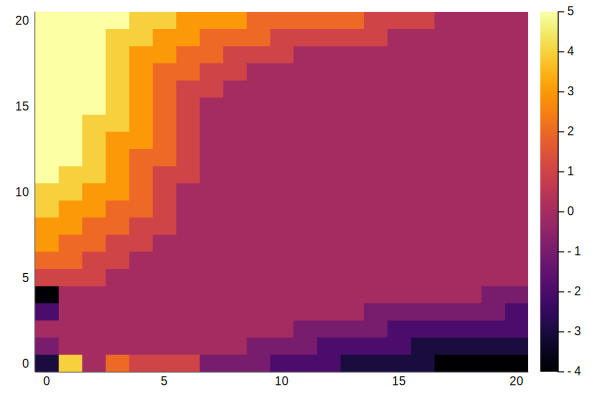

In [5]:
heatmap(0:MaxCars, 0:MaxCars, reshape([decode_action(x) for x in p.table], 1+MaxCars,1+MaxCars))

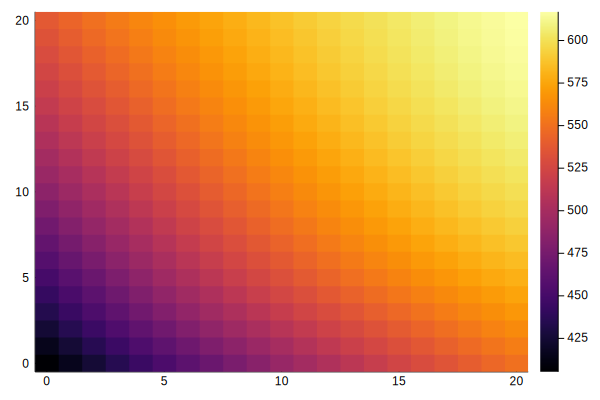

In [6]:
heatmap(0:MaxCars, 0:MaxCars, reshape(V.table, 1+MaxCars,1+MaxCars))